In [1]:
cols.subtypes=c(alpha1='darkred',alpha2='lightpink',
               beta1='darkgreen',beta2='lightgreen',
               gamma1='orange',gamma2='gold')

In [3]:
require(tidyverse)
require(data.table)
require(ggplot2)
require(chromVAR)
require(SummarizedExperiment)
require(RColorBrewer)
require(pheatmap)
require(ggdendro)
require(extrafont)  # fonts 
# https://blog.revolutionanalytics.com/2012/09/how-to-use-your-favorite-fonts-in-r-charts.html
suppressMessages(loadfonts())
require(ggthemes)
# #https://rpubs.com/Koundy/71792 theme_Publication
require(ComplexHeatmap)
cols.hm.avg.tf <- colorRampPalette(c(rgb(249, 249, 212, maxColorValue = 255), rgb(60, 
    181, 195, maxColorValue = 255), rgb(30, 35, 86, maxColorValue = 255)), space = "Lab")

require(ggpubr)

theme_pubr<- function (base_size = 11, base_family = "Arial") 
{
    theme_foundation() + theme(line = element_line(colour = "black", 
        lineend = "round", linetype = "solid"), rect = element_rect(fill = "white", 
        colour = "black", linetype = "solid"), text = element_text(colour = "black", 
        face = "plain", family = base_family, size = base_size, 
        vjust = 0.5, hjust = 0.5, lineheight = 0.5), panel.background = element_blank(), 
        plot.background = element_blank(), panel.border = element_rect(colour = "black", 
            fill = NA), panel.grid = element_blank(), strip.background = element_rect(colour = NA), 
        legend.key = element_rect(colour = NA), title = element_text(size = rel(1)), 
        plot.title = element_text(size = rel(1.2), face = "bold"), 
        strip.text = element_text(), axis.ticks.length = unit(1, 
    "mm"))
}

## 1. chromVar

### 1.1 plot all variable motifs

#### 1.1.0 variable motifs selection

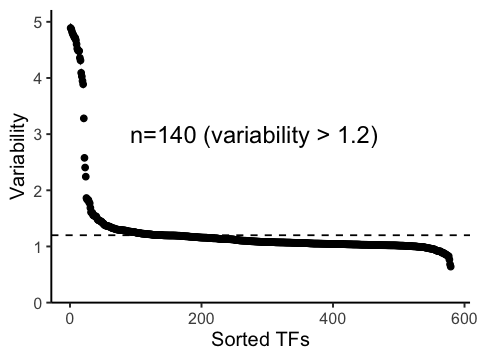

In [17]:
options(repr.plot.width = 4, repr.plot.height = 3)
variability <- read.csv("../dat/1910_v2/output.jaspar.var.res.csv", row.names = 1)
plotVariability(variability, use_plotly = FALSE, labels = "", ) + geom_hline(yintercept = 1.2, 
    linetype = 2) + annotate("text", x = 280, y = 3, label = paste0("n=", nrow(subset(variability, 
    variability > 1.2)), " (variability > 1.2)"), family = "Arial", size = 5) + theme(text = element_text(family = "Arial"))
ggsave(filename = "../figures/Fig1/subfigs/subfig1s.select_varible_motifs.pdf", width = 4, 
    height = 3, useDingbats = F)

#### 1.1.1 plot heatmap + dendrogram

pdf 
  2

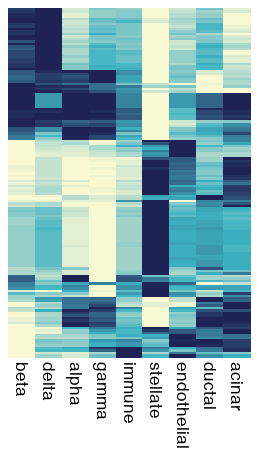

In [5]:
## original
pd.list <- readRDS("../dat/1910_v2/Fig1E.Rdata")
options(repr.plot.width = 1.08 * 2, repr.plot.height = 3.84)
callback = function(hc, mat) {
    # sv <- apply(mat, 1, which.max)
    dend = (as.dendrogram(hc))
    as.hclust(dend)
}

p <- pheatmap(pd.list$pd, scale = "none", cluster_rows = F, cluster_cols = F, legend = F, 
    show_colnames = T, show_rownames = F, border_color = NA, color = cols.hm.avg.tf(30))

pdf("../figures/Fig1/subfigs/Fig1E.variable.motifs.hm.pdf", fonts = "Arial", width = 1.08 * 
    2, height = 3.84, family = "Arial")
print(p)
dev.off()
system("open ../figures/Fig1/subfigs/Fig1E.variable.motifs.hm.pdf")
fwrite(pd.list$pd, "../figures/Fig1/subfigs/Fig1E.variable.motifs.hm.csv", row.names = T)
system("open ../figures/Fig1/subfigs/Fig1E.variable.motifs.hm.csv")

pdf 
  2

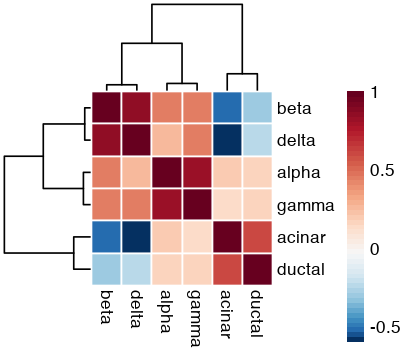

In [14]:
require(pals)
options(repr.plot.width = 3.4, repr.plot.height = 3)
cor.mat <- cor(pd.list$pd %>% select(beta, delta, alpha, gamma, acinar, ductal))
cl_cb <- function(hcl, mat) {
    as.hclust(reorder(as.dendrogram(hcl), 1:6))
}

p2 <- pheatmap(cor.mat, scale = "none", clustering_method = "ward.D2", border_color = "white", 
    fontsize = 10, display_numbers = F, cluster_rows = T, cluster_cols = T, color = colorRampPalette(rev(brewer.rdbu(11)), 
        bias = 1.5)(51), clustering_callback = cl_cb)  #, legend_breaks = c(-0.2, 1)
pdf("../figures/Fig1/subfigs/fig1.motif.cor.pdf", fonts = "Arial", width = 3.5, height = 3, 
    family = "Arial")
print(p2)
dev.off()
system("open ../figures/Fig1/subfigs/fig1.motif.cor.pdf")
fwrite(cor.mat%>%as.data.frame, "../figures/Fig1/subfigs/fig1.motif.cor.csv", 
    row.names = T)
system("open ../figures/Fig1/subfigs/fig1.motif.cor.csv")

In [42]:
pd.list <- readRDS("../dat/figdata/Fig1E.Rdata")

head(pd.list$pd, 1)
pd.list$pd %>% dim

## add jasper id
ttest.res <- fread("~/Dropbox (UCSD_Epigenomics)/workReports/2019-08-27_islet/chromVar_ttest_res.csv") %>% 
    select(motif, id) %>% unique
all(rownames(pd.list$pd) %in% ttest.res$motif)

pd.list$pd <- pd.list$pd %>% rownames_to_column("motif") %>% left_join(ttest.res)
head(pd.list$pd, 1)
pd.list$pd %>% dim


## add motifdb
tfclass.db.dic <- readRDS("~/github/atacMotif/db/dic_jaspar_tfclass.rds")
if (F) {
    all(pd.list$pd$id %in% tfclass.db.dic$merged$jaspar.id)
    pd.list$pd$id[!(pd.list$pd$id %in% tfclass.db.dic$merged$jaspar.id)]
    lapply(which(!(pd.list$pd$id %in% tfclass.db.dic$merged$jaspar.id)), function(idx) {
        id <- pd.list$pd$id[idx]
        id.2 <- sub(".[0-9]$", "", id)
        tfclass.db.dic$merged[grep(id.2, tfclass.db.dic$merged$jaspar.id), ] %>% 
            mutate(motif = rownames(pd.list$pd)[idx])
    })
    ## FOS:Jun will much multiple TF
}

all(pd.list$pd$motif %in% tfclass.db.dic$merged$jaspar.name)

pd.list$pd <- pd.list$pd %>% left_join(tfclass.db.dic$merged %>% select(jaspar.name, 
    family.id, family.name) %>% unique, by = c(motif = "jaspar.name"))
head(pd.list$pd, 1)
pd.list$pd %>% dim  #116 vs 113. with multiple family match (eg - FOS:Jun)

## adding supergroup + class
tfclass.db <- readRDS("~/github/atacMotif/db/tfclass.rds")

pd.list$pd <- pd.list$pd %>% mutate(class.id = sub(".[0-9]+$", "", family.id), superclass.id = sub(".[0-9]+.[0-9]+$", 
    "", family.id)) %>% left_join(tfclass.db$class, by = c(class.id = "id")) %>% 
    left_join(tfclass.db$superclass, by = c(superclass.id = "id")) %>% select(-starts_with("about")) %>% 
    dplyr::rename(class.name = name.x, superclass.name = name.y)
head(pd.list$pd, 1)
pd.list$pd %>% dim  #116 vs 113. with multiple family match (eg - FOS:Jun)

## duplicated
pd.list$pd %>% filter(motif %in% pd.list$pd$motif[duplicated(pd.list$pd$motif)])

## plot
options(repr.plot.width = 1.08 * 2, repr.plot.height = 3.84)
p <- pheatmap(pd.list$pd[, 2:10], scale = "none", cluster_rows = F, legend = F, annotation_row = pd.list$pd %>% 
    select(family.id), show_rownames = F, show_colnames = T, cluster_cols = T, border_color = NA, 
    color = cols.hm.avg.tf(30))
print(p)

,stellate,glial,endothelial,immune,exocrine,gamma,alpha,delta,beta
FOXC1,0.329117,0,0.4609349,0.409998,0.6651862,0.9791956,1,0.6090911,0.8064719


[1] 111   9

[1] TRUE

Joining, by = "motif"


motif,stellate,glial,endothelial,immune,exocrine,gamma,alpha,delta,beta,id
FOXC1,0.329117,0,0.4609349,0.409998,0.6651862,0.9791956,1,0.6090911,0.8064719,MA0032.2


[1] 111  11

[1] TRUE

motif,stellate,glial,endothelial,immune,exocrine,gamma,alpha,delta,beta,id,family.id,family.name
FOXC1,0.329117,0,0.4609349,0.409998,0.6651862,0.9791956,1,0.6090911,0.8064719,MA0032.2,3.3.1,FOX


[1] 116  13

motif,stellate,glial,endothelial,immune,exocrine,gamma,alpha,delta,beta,id,family.id,family.name,class.id,superclass.id,class.name,superclass.name
FOXC1,0.329117,0,0.4609349,0.409998,0.6651862,0.9791956,1,0.6090911,0.8064719,MA0032.2,3.3.1,FOX,3.3,3,Fork head / winged helix factors,Helix-turn-helix domains


[1] 116  17

motif,stellate,glial,endothelial,immune,exocrine,gamma,alpha,delta,beta,id,family.id,family.name,class.id,superclass.id,class.name,superclass.name
TAL1::TCF3,0.2568238,0.04750743,0.3756461,0.2380997,0.0000000,0.7006125,0.9183576,1.0000000,0.9798271,MA0091.1,1.2.3,Tal-related,1.2,1,Basic helix-loop-helix factors (bHLH),Basic domains
TAL1::TCF3,0.2568238,0.04750743,0.3756461,0.2380997,0.0000000,0.7006125,0.9183576,1.0000000,0.9798271,MA0091.1,1.2.1,E2A,1.2,1,Basic helix-loop-helix factors (bHLH),Basic domains
GATA1::TAL1,0.1370577,0.00000000,0.5676871,0.2995350,0.9825110,0.9706992,1.0000000,0.6288900,0.3611637,MA0140.2,1.2.3,Tal-related,1.2,1,Basic helix-loop-helix factors (bHLH),Basic domains
GATA1::TAL1,0.1370577,0.00000000,0.5676871,0.2995350,0.9825110,0.9706992,1.0000000,0.6288900,0.3611637,MA0140.2,2.2.1,C4-GATA-related,2.2,2,Other C4 zinc finger-type factors,Zinc-coordinating DNA-binding domains
FOS::JUN,0.9965626,1.00000000,0.5483645,0.4916527,0.5572962,0.0000000,0.1445080,0.4131483,0.3360419,MA0099.2,1.1.1,Jun-related,1.1,1,Basic leucine zipper factors (bZIP),Basic domains
FOS::JUN,0.9965626,1.00000000,0.5483645,0.4916527,0.5572962,0.0000000,0.1445080,0.4131483,0.3360419,MA0099.2,1.1.2,Fos-related,1.1,1,Basic leucine zipper factors (bZIP),Basic domains
BATF::JUN,0.9629505,1.00000000,0.5609485,0.4446117,0.5126267,0.0000000,0.1146191,0.3717273,0.2928471,MA0462.1,1.1.1,Jun-related,1.1,1,Basic leucine zipper factors (bZIP),Basic domains
BATF::JUN,0.9629505,1.00000000,0.5609485,0.4446117,0.5126267,0.0000000,0.1146191,0.3717273,0.2928471,MA0462.1,1.1.4,B-ATF-related,1.1,1,Basic leucine zipper factors (bZIP),Basic domains
MAF::NFE2,1.0000000,0.96645649,0.4876286,0.5029710,0.5328437,0.0000000,0.1797340,0.3926687,0.3832105,MA0501.1,1.1.1,Jun-related,1.1,1,Basic leucine zipper factors (bZIP),Basic domains
MAF::NFE2,1.0000000,0.96645649,0.4876286,0.5029710,0.5328437,0.0000000,0.1797340,0.3926687,0.3832105,MA0501.1,1.1.3,Maf-related,1.1,1,Basic leucine zipper factors (bZIP),Basic domains


ERROR: Error in annotation_colors[[colnames(annotation)[i]]]: subscript out of bounds


In [55]:
fwrite(pd.list$pd, "./fig1e.csv")
pd.list$pd$family.id[!pd.list$pd$family.id %in% names(col.f)]
pd.list$pd <- fread("./fig1e.csv") # after mannually input MAFG
pd.list$pd$family.id[!pd.list$pd$family.id %in% names(col.f)]

[1] "3.1.8"

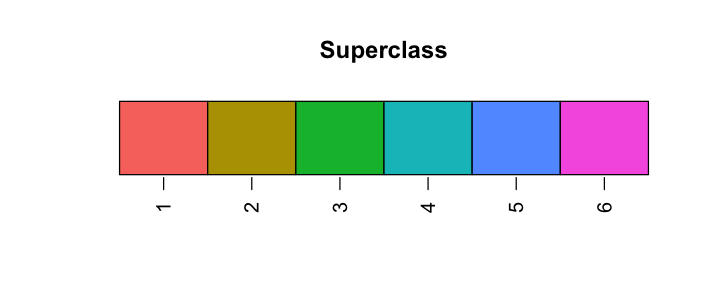

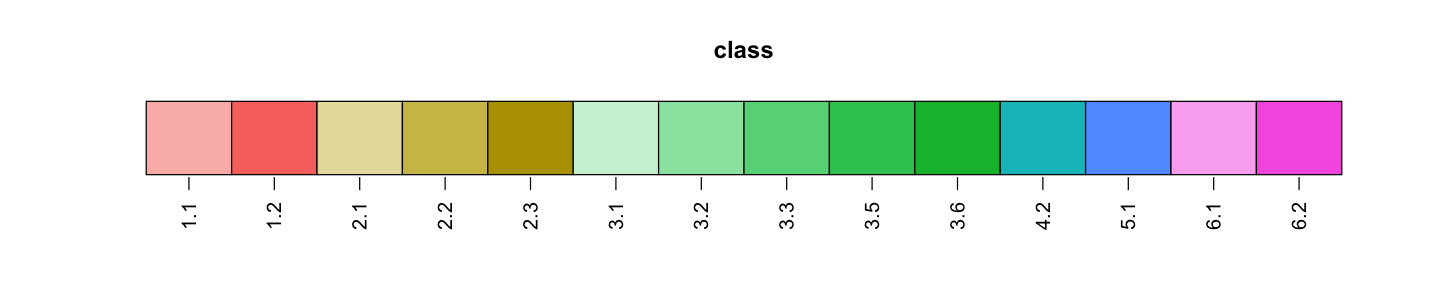

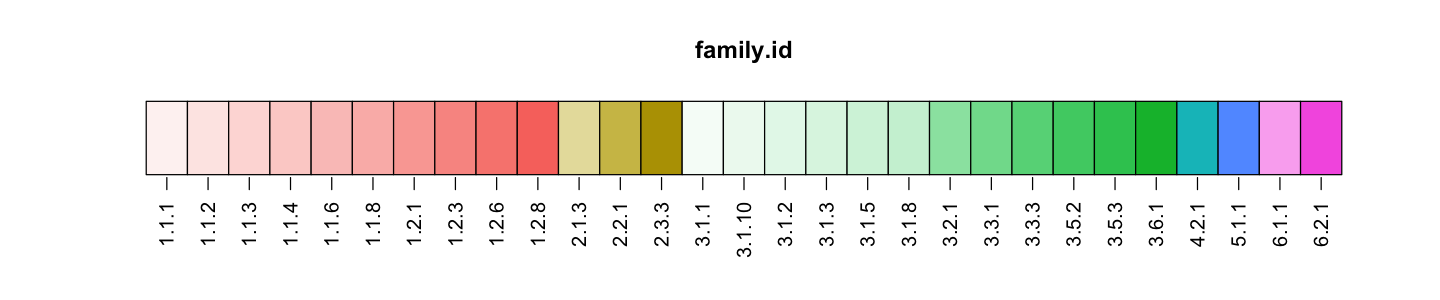

In [109]:
require(scales)

options(repr.plot.width = 6, repr.plot.height = 2.5)
fun.plot_all <- function(col.sc = hue_pal()(7), dat = ttest.res.motifdb) {
    
    n.sc <- dat %>% pull(superclass.id) %>% unique %>% length
    ## fun.plot
    fun.plot <- function(n = n.sc, labs = 1:n.sc, col.input = col.sc, ...) {
        plot(c(0, 1), c(0, 1), type = "n", xlab = "", ylab = "", bty = "n", xaxt = "n", 
            yaxt = "n", ...)
        edgs <- seq(0, 1, length.out = n + 1)
        delta <- edgs[2] - edgs[1]
        i <- 1:n
        axis(1, at = edgs[-1] - delta/2, labels = labs, las = 2, lwd = 0, lwd.ticks = 1)
        rect(edgs[i], 0, edgs[i + 1], 1, col = col.input)
    }
    
    
    fun.plot(main = "Superclass", col.input = col.sc)
    pd.tmp <- dat %>% select(class.id, superclass.id) %>% unique %>% pull(superclass.id) %>% 
        table
    col.c <- unlist(lapply(names(pd.tmp), function(i) {
        ii = as.numeric(i)
        tmp.cols <- colorRampPalette(c("white", col.sc[ii]))(pd.tmp[i] %>% as.numeric + 
            1)
        tmp.cols[-1]
    }))
    
    
    fun.plot(n = length(col.c), col.input = col.c, labs = dat %>% arrange(class.id) %>% 
        pull(class.id) %>% unique, main = "class")
    
    pd.tmp <- dat %>% select(family.id, class.id) %>% unique %>% pull(class.id) %>% 
        table
    names(col.c) <- names(pd.tmp)
    col.f <- unlist(lapply(names(pd.tmp), function(i) {
        n.pre <- as.character(as.numeric(i) - 0.1)
        c.start = ifelse(n.pre %in% names(pd.tmp), col.c[n.pre], ifelse(as.character(as.numeric(i) - 
            0.2) %in% names(pd.tmp), col.c[as.character(as.numeric(i) - 0.2)], "white"))
        
        tmp.cols <- colorRampPalette(c(c.start, col.c[i]))(pd.tmp[i] %>% as.numeric + 
            1)
        tmp.cols[-1]
    }))
    names(col.f) <- dat %>% arrange(family.id) %>% pull(family.id) %>% unique
    options(repr.plot.width = 12, repr.plot.height = 2.5)
    fun.plot(n = length(col.f), col.input = col.f, labs = names(col.f), main = "family.id", 
        cex = 0.5)
    col.f
}
#col.f <- fun.plot_all(col.sc = brewer.pal(n = 8, name = "Set1")[c(1:3,8, 7,4)], dat = pd.list$pd)
col.f <- fun.plot_all(col.sc = hue_pal()(6), dat = pd.list$pd)

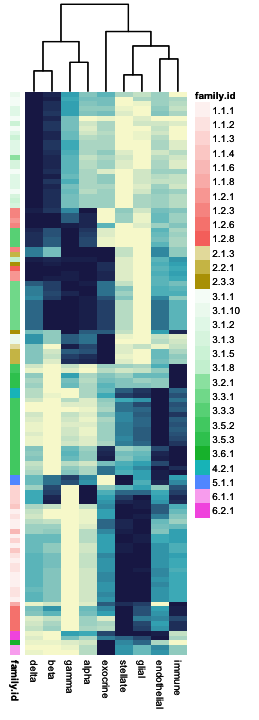

In [110]:
options(repr.plot.width = 1.08 * 2, repr.plot.height = 6)
pd <- pd.list$pd %>% rowid_to_column("idx") %>% column_to_rownames("idx")
anno_colors <- list(family.id = col.f)
anno_row <- pd %>% select(family.id) %>% mutate(family.id = as.factor(family.id))


# col.f <- readRDS('./col.f.rds') rownames(pd.list$pd[,
# 2:10])rownames(pd.list$pd%>%select(family.id))

p <- pheatmap(pd[, 2:10], scale = "none", cluster_rows = T, treeheight_row = 0, annotation_colors = anno_colors, 
    annotation_row = anno_row, legend = F, show_rownames = F, show_colnames = T, 
    border_color = NA, color = cols.hm.avg.tf(30), fontsize = 6)
print(p)

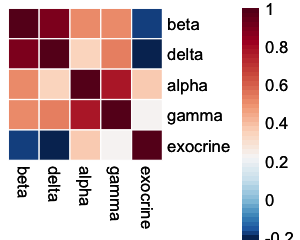

In [7]:
require(pals)
options(repr.plot.width = 2.5, repr.plot.height = 2)
cor.mat <- cor(pd.list$pd)
p2 <- pheatmap(cor.mat[c("beta", "delta", "alpha", "gamma", "exocrine"), c("beta", 
    "delta", "alpha", "gamma", "exocrine")], scale = "none", border_color = "white", 
    fontsize = 10, display_numbers = F, cluster_rows = F, cluster_cols = F, color = colorRampPalette(rev(brewer.rdbu(11)), 
        bias = 1.5)(51))#, legend_breaks = c(-0.2, 1)
#pdf("~/Dropbox (UCSD_Epigenomics)/workReports/2019-09_islet_rev/Fig.1.motif.cor.pdf", 
#    fonts = "Arial", width = 2.5, height = 2, family = "Arial")
print(p2)
#dev.off()

In [34]:
res.motifs <- lapply(colnames(pd.list$pd), function(ct) pd.list$pd %>% rownames_to_column("motif") %>% 
    gather(2:10, key = "celltype", value = "avgZ") %>% filter(celltype == ct) %>% 
    top_n(1) %>% pull(motif))
names(res.motifs) <- colnames(pd.list$pd)

Selecting by avgZ
Selecting by avgZ
Selecting by avgZ
Selecting by avgZ
Selecting by avgZ
Selecting by avgZ
Selecting by avgZ
Selecting by avgZ
Selecting by avgZ


In [35]:
res.motifs

$stellate
 [1] "TFEB"        "TFEC"        "TFE3"        "USF2"        "USF1"       
 [6] "ATF7"        "JDP2(var.2)" "BATF3"       "NFE2"        "FOSL2"      
[11] "JUNB"        "FOS"         "JUND"        "JDP2"        "FOSL1"      
[16] "MAF::NFE2"   "MEF2D"       "MEF2B"      

$glial
[1] "JUND(var.2)" "JUN"         "ATF4"        "JUN(var.2)"  "FOS::JUN"   
[6] "BATF::JUN"   "STAT3"      

$endothelial
 [1] "STAT1" "ELF1"  "FLI1"  "ETS1"  "ELK3"  "ERG"   "ERF"   "ETV4"  "FEV"  
[10] "ELK1"  "ELK4"  "ETV2"  "NFYA"  "NFYB" 

$immune
 [1] "CEBPA" "ELF4"  "ETV6"  "EHF"   "ELF3"  "ELF5"  "IRF9"  "IRF8"  "IRF2" 
[10] "SPIC"  "SPI1" 

$exocrine
 [1] "ZEB1"  "GATA2" "GATA3" "GATA5" "HNF4G" "HNF1A" "HNF1B" "REL"   "RELA" 
[10] "TEAD3"

$gamma
 [1] "FOXC2" "FOXA1" "FOXL1" "FOXI1" "FOXD2" "FOXO4" "FOXO6" "FOXP3" "RFX2" 
[10] "RFX3"  "RFX4"  "RFX5"  "CTCF" 

$alpha
 [1] "FOXC1"       "FOXB1"       "TCF3"        "TCF4"        "ID4"        
 [6] "NEUROG2"     "GATA1::TAL1" "MAFK"        "MAFF"        "MAFG"       
[11] "NRL"        

$delta
 [1] "SNAI2"      "MSC"        "TAL1::TCF3" "NKX6-1"     "NKX6-2"    
 [6] "MEOX1"      "EVX2"       "POU6F2"     "EMX2"       "EMX1"      
[11] "LBX1"       "LHX9"       "ISX"        "RAX2"       "GBX1"      
[16] "GBX2"       "DLX6"       "LHX2"       "LHX6"       "GSX1"      
[21] "PDX1"       "PRRX1"      "SHOX"       "PAX4"       "NOTO"      
[26] "VAX2"       "VAX1"      

$beta
[1] "MSC"

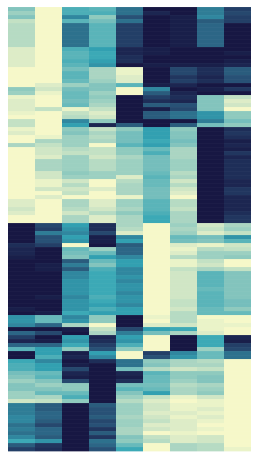

In [4]:
options(repr.plot.width = 1.08 * 2, repr.plot.height = 3.84)

pd.list <- readRDS("../dat/figdata/Fig1E.Rdata")
# pheatmap(pd.list$pd, scale = "none", cluster_rows = F, legend = F, cluster_cols = F, 
 #   clustering_callback = callback, clustering_method = "ward.D2", treeheight_row = 0, 
#    show_rownames = T, fontsize_row = 5, border_color = NA, color = cols.hm.avg.tf(30))
p<-pheatmap(pd.list$pd, scale = "none", cluster_rows = F, legend = F, show_rownames = F, 
    show_colnames = F, cluster_cols = F, border_color = NA, color = cols.hm.avg.tf(30))
print(p)
pdf(file = "/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-05_figs/fig1_E.heatmap.pdf", 
    height = 384/72, width = 108/72)
print(p)
dev.off()
write.csv(pd.list$pd[,9:1],'/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-05_figs/fig_1E.motif_heatmap.csv')



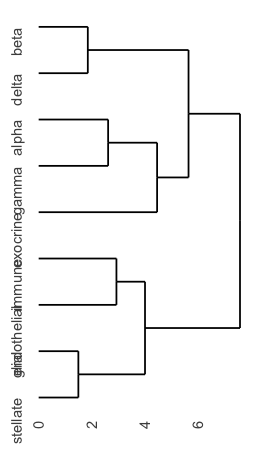

In [18]:
p <- ggdendrogram(pd.list$hc, size = 2) + coord_flip()
p
ggsave(plot = p + theme_dendro(), filename = "/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-05_figs/fig1_E.dendro.pdf", 
    width = 36/72, height = 108/72)

### 1.2 Select subtype variable motifs

In [30]:
all.equal(ttest.res.pd$FDR.bak,ttest.res.pd$FDR)

[1] TRUE

In [29]:
ttest.res.pd <- fread("../figures/Fig2/subfigs/fig2D_sub_vs_sub.csv") %>% group_by(enrichedIn) %>% 
    mutate(min.FDR = min(ttest.res.pd$FDR[ttest.res.pd$FDR != 0]), FDR.bak = FDR, 
        delta = mean_x - mean_y, celltype = sub("_1", "", x)) %>% mutate(FDR = ifelse(FDR == 
    0, min.FDR, FDR), selected = FDR < 0.01 & abs(delta) > 0.5) %>% mutate(type = ifelse(delta > 
    0, 1, 2)) %>% select(motif, jaspar.id, x, y, mean_x, mean_y, celltype, enrichedIn, 
    pval, FDR, delta, selected, min.FDR, FDR.bak) %>% unique

ttest.res.pd %>% head(1)
(ttest.res.pd %>% nrow)/3

motif,jaspar.id,x,y,mean_x,mean_y,celltype,enrichedIn,pval,FDR,delta,selected,min.FDR,FDR.bak
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
NEUROD1,MA1109.1,alpha_1,alpha_2,0.1334647,-1.673909,alpha,alpha_1,9.501045e-240,2.200442e-238,1.807373,TRUE,1.114618e-308,2.200442e-238


[1] 579

Adding missing grouping variables: `enrichedIn`


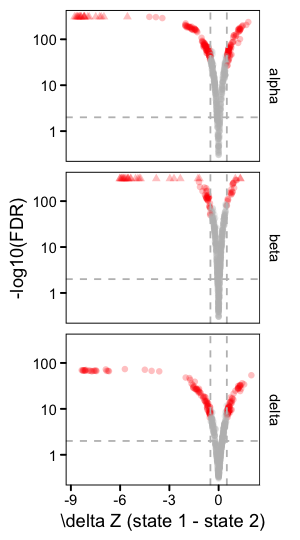

In [35]:
options(repr.plot.width = 2.5, repr.plot.height = 4.5)


plt.volcano.ttest <- ggplot(ttest.res.pd, aes(delta, -log10(FDR))) + geom_point(aes(color = selected), 
    shape = ifelse(ttest.res.pd$FDR.bak < ttest.res.pd$min.FDR, 17, 16), alpha = 0.25) + 
    theme_pubr() + geom_hline(yintercept = 2, linetype = 2, color = "grey") + geom_vline(xintercept = c(-0.5, 
    0.5), linetype = 2, color = "grey") + scale_y_log10() + scale_color_manual(values = c("grey", 
    "red")) + theme(legend.position = "none") + facet_grid(celltype ~ .) + xlab("\\delta Z (state 1 - state 2)")

print(plt.volcano.ttest)

ggsave(paste0("../figures/Fig2/subfigs/fig2_sub_vs_sub.volcation.motif_selection.pdf"), 
    width = 2.5, height = 4.5, units = "in", useDingbats = F)
system(paste0("open ../figures/Fig2/subfigs/fig2_sub_vs_sub.volcation.motif_selection.pdf"))
fwrite(plt.volcano.ttest$data %>% select(celltype, motif, delta, selected, FDR), 
    "../figures/Fig2/subfigs/fig2_sub_vs_sub.volcation.motif_selection.csv")
system("open ../figures/Fig2/subfigs/fig2_sub_vs_sub.volcation.motif_selection.csv")

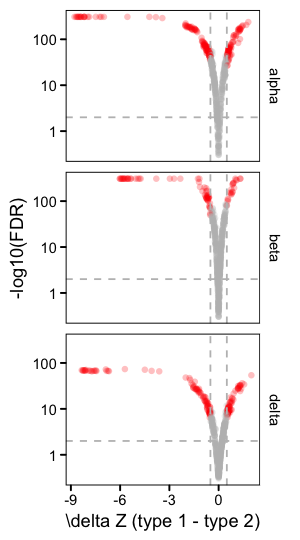

In [32]:
options(repr.plot.width = 2.5, repr.plot.height = 4.5)


plt.volcano.ttest <- ggplot(ttest.res.pd, aes(delta, -log10(FDR))) + geom_point(aes(color = selected), 
    shape = ifelse(ttest.res.pd$FDR < ttest.res.pd$min.FDR, 17, 16), alpha = 0.25) + 
    theme_pubr() + geom_hline(yintercept = 2, linetype = 2, color = "grey") + geom_vline(xintercept = c(-0.5, 
    0.5), linetype = 2, color = "grey") + scale_y_log10() + scale_color_manual(values = c("grey", 
    "red")) + theme(legend.position = "none") + facet_grid(celltype ~ .) + xlab("\\delta Z (type 1 - type 2)")

print(plt.volcano.ttest)

# ggsave(filename = '/Users/frank/Dropbox
# (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/sfigs/fig_s2.select_subtype_motifs.pdf',
# width = 2.5, height = 4.5, useDingbats = F)

### 1.3 plot motif heatmap for alpha and beta cells

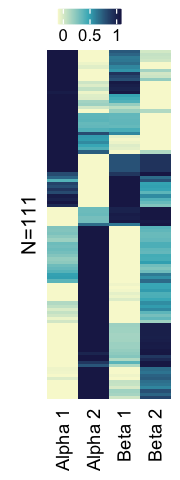

In [11]:
options(repr.plot.width = 1.5, repr.plot.height = 4)

# calc_varability_heatmap_on_subtypes_ab.R
pd.fig_2B.motif_heatmap_ab <- read.csv("~/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs//fig2/fig_2B.motif_heatmap_ab.csv", 
    row.names = 1)
colnames(pd.fig_2B.motif_heatmap_ab) <- c("Alpha 1", "Alpha 2", "Beta 1", "Beta 2")
ht <- Heatmap(pd.fig_2B.motif_heatmap_ab, col = cols.hm.avg.tf(30), cluster_columns = F, 
    cluster_rows = F, row_title = paste0("N=", nrow(pd.fig_2B.motif_heatmap_ab)), 
    row_title_side = "left", row_title_gp = gpar(fontsize = 12), show_column_names = T, 
    show_row_names = F, column_names_gp = gpar(fontsize = 11), name = "", show_heatmap_legend = T, 
    heatmap_legend_param = list(at = c(0, 0.5, 1), title_gp = gpar(fontsize = 9), 
        grid_border = "black", color_bar = "continuous", grid_height = unit(3, "mm"), 
        legend_direction = "horizontal"), show_row_dend = F, combined_name_fun = NULL)
draw(ht, heatmap_legend_side = "top")
# pdf('fig_2B.motif_heatmap_ab.pdf',height = 4,width = 2,family = 'Arial')
# draw(ht, heatmap_legend_side = 'top') dev.off()

### 1.4 violin plot for motif (between celltypes)

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”

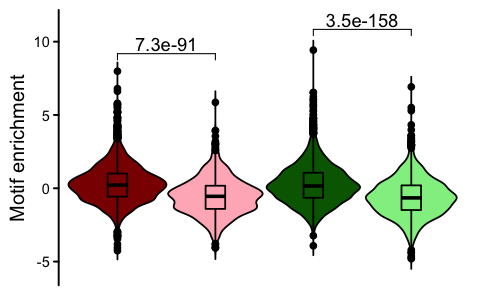

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”

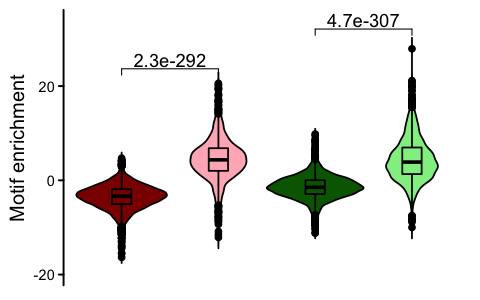

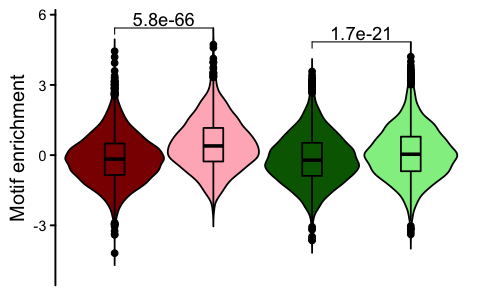

In [49]:
pd.fig_2B.motif_violin_ab <- fread(file = "../dat/fig_2B.motif_violin_ab.csv") %>% 
    mutate(cluster = factor(cluster, levels = c("Alpha 1", "Alpha 2", "Beta 1", "Beta 2")))

options(repr.plot.width = 4, repr.plot.height = 2.5)
fun.plotMofifGG <- function(m) {
    pd <- pd.fig_2B.motif_violin_ab %>% filter(Motif.name == m)
    pd.m <- pd %>% ungroup() %>% group_by(cluster) %>% summarise(mmin = min(zval), 
        mmax = max(zval)) %>% as.data.frame() %>% column_to_rownames("cluster")
    mmin <- min(pd$zval)
    mmax <- max(pd$zval)
    ggviolin(pd, x = "cluster", y = "zval", size = 0.5, shape = 16, add = "boxplot", 
        add.params = list(size = 0.5), fill = "cluster", ylab = "Motif enrichment") + 
        stat_pvalue_manual(data = ttest.res.pd %>% filter(motif == m) %>% ungroup() %>% 
            mutate(group1 = c("Alpha 1", "Beta 1"), font.label = list(size = 10), 
                group2 = c("Alpha 2", "Beta 2"), FDR = signif(FDR, 2), label.size = 10, 
                y.position = c(max(pd.m[c("Alpha 1", "Alpha 2"), "mmax"]) * 1.15, 
                  max(pd.m[c("Beta 1", "Beta 2"), "mmax"]) * 1.15)), label = "FDR", 
            xmin = "group1", xmax = "group2", y.position = "y.position") + coord_cartesian(expand = T, 
        ylim = c(mmin * 1.2, mmax * 1.2)) + theme_pubr() + theme(legend.position = "none", 
        axis.text.x = element_blank(), axis.title.x = element_blank(), title = element_text(size = 12, 
            hjust = 0.5), text = element_text(family = "Arial"), panel.border = element_rect(colour = NA), 
        axis.ticks.x = element_blank(), axis.line.x = element_blank(), axis.line = element_line(colour = "black")) + 
        scale_fill_manual(values = c("darkred", "lightpink", "darkgreen", "lightgreen"))
}

fun.plotMofifGG("RFX3")
ggsave(filename = "/Users/frank/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/fig2/fig_2B.motif_violin_ab_RFX3.pdf", 
    width = 2.8319, height = 1.5, useDingbats = F)
fun.plotMofifGG("FOS::JUN")
ggsave(filename = "/Users/frank/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/fig2/fig_2B.motif_violin_ab_FOS_JUN.pdf", 
    width = 2.8319, height = 1.5, useDingbats = F)

fun.plotMofifGG("XBP1")
ggsave(filename = "/Users/frank/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/fig2/fig_2B.motif_violin_ab_XBP1.pdf", 
    width = 2.8319, height = 1.5, useDingbats = F)

### 1.5 UMAP scatter

In [11]:
input.chromVar.res.list <- readRDS(file = "../dat/1910_v2/output.jaspar.dev.res.Rdata")
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z
input.umap.res <- fread("../dat/1910_v2/islet.cluster_labels.filt.txt", header = T) %>% 
    separate(cluster_name, into = c("cell_type_overall", "subtype"), remove = F) %>% 
    dplyr::rename(barcodes = "index", cluster = "cluster_name")


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 772 rows [3, 50, 83, 84, 138, 181, 196, 213, 253, 265, 274, 301, 303, 353, 371, 388, 412, 434, 491, 495, ...].”

In [20]:
input.chromVar.jaspar.z.trimmed <- input.chromVar.jaspar.z
input.chromVar.jaspar.z.trimmed[input.chromVar.jaspar.z.trimmed>3] <- 3
input.chromVar.jaspar.z.trimmed[input.chromVar.jaspar.z.trimmed< -3] <- -3

In [21]:
fun.plot.project.motif <- function(motif, input.chromVar.z = input.chromVar.jaspar.z.trimmed, 
    umap.res = input.umap.res, rescale = F, cls = rev(brewer.pal(n = 11, "RdBu")), 
    bks = c(-5, 0, 5)) {
    require(scales)
    
    motif.idx <- grep(motif, rownames(input.chromVar.z))
    if (length(motif.idx) == 0) {
        message(motif, " is not found!")
        return()
    }
    
    motif.z <- input.chromVar.z[motif.idx[1], ]
    if (rescale) {
        sc <- max(abs(quantile(motif.z, probs = c(0.05, 0.95))))
        motif.z[motif.z > sc] <- sc
        motif.z[motif.z < -sc] <- -sc
    }
    
    motif.z <- motif.z %>% as.data.frame() %>% rownames_to_column("barcodes")
    colnames(motif.z)[2] <- "zval"
    
    tmp <- umap.res %>% right_join(motif.z)
    
    p.default.cluster.motif <- ggplot(tmp, aes(UMAP1, UMAP2)) + geom_point(aes(colour = zval), 
        size = 0.2, shape = 16) + ggtitle(rownames(input.chromVar.jaspar.z)[motif.idx]) + 
        scale_color_gradientn(colours = cls, breaks = bks) + theme_pubr() + theme(text = element_blank(), 
        axis.ticks = element_blank(), legend.position = c(0.2, 0.9), legend.direction = "horizontal", 
        legend.key.width = unit(2, "mm"), legend.key.height = unit(0.1, "inches"), 
        legend.text = element_text(size = 10,family = "Arial"), legend.background = element_rect(fill = "transparent", 
            colour = "transparent"), plot.margin = unit(c(1, 1, -1, -1), "mm"))
    
    p.default.cluster.motif
}

Joining, by = "barcodes"
Joining, by = "barcodes"
Joining, by = "barcodes"


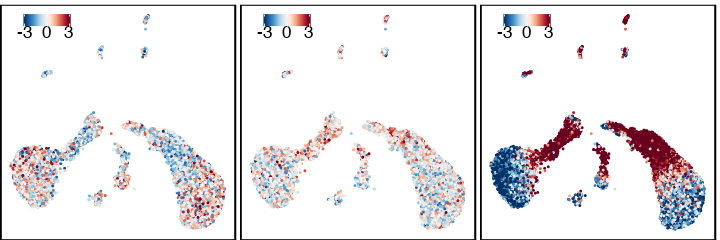

In [22]:
options(repr.plot.width = 6, repr.plot.height = 2)

ps <- lapply(c("RFX3", "XBP1", "FOS::JUN"), fun.plot.project.motif, bks = c(-3, 0, 
    3))
names(ps) <- c("RFX3", "XBP1", "FOS::JUN")
ggarrange(plotlist = ps, ncol = 3)



### 1.6 Motif pseduostates

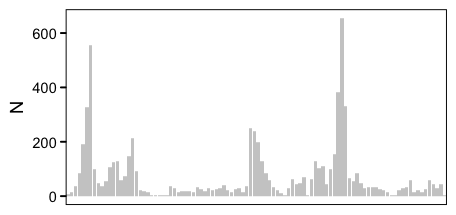

In [8]:
## beta ps bin
ps.bin.dat.sum <- fread('../dat/figdata/ps.bin.dat.sum.csv')
options(repr.plot.width = 548.276/72/2, repr.plot.height = 258.924/72/2)

p <- ggplot(ps.bin.dat.sum %>% filter(celltype == "beta") %>% droplevels(), aes(ps_bin, 
    N)) + geom_bar(stat = "identity", fill = "grey80") + theme_pubr() + theme(axis.title.x = element_blank()) + 
    scale_x_discrete(breaks = c(0, 50, 100))
print(p)
#ggsave(p + theme(axis.title = element_blank(), axis.text = element_blank()), filename = "/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-05_figs/fig2D_beta_ps_histogram.pdf", 
#    width = 176/72, height = 36/72)

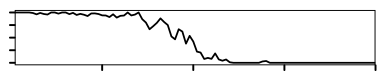

In [85]:
options(repr.plot.width = 154.196/72 * 1.5, repr.plot.height = 6/72 * 8)
pd <- ps.bin.dat.sum %>% filter(celltype == "beta") %>% droplevels() %>% ungroup()%>%
    mutate(ps_bin.idx=as.numeric(factor(ps_bin,levels=ps_bin)))
#head(pd)
ggplot(pd) + geom_line(aes(ps_bin.idx, frac)) + theme_pubr()+coord_cartesian(expand = F)+
ylim(-0.05,1.05)+theme(text = element_blank())
ggsave(paste0("/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-12_figs/fig2D_beta_ps_frac.pdf"),width=154.196/72 * 1.5,
     height=6/72 * 8,useDingbats = F)

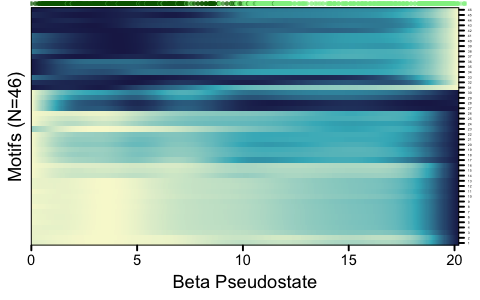

In [11]:
pd.fig_2.motif.beta.pesudostate <- readRDS("../dat/figdata/fig_2.motif.beta.pesudostate.hm.Rds")


pd <- pd.fig_2.motif.beta.pesudostate$pd %>% as.data.frame() %>% rownames_to_column("motif") %>% 
    gather(key = "ps.idx", value = "zval", -1) %>% mutate(ps = (as.numeric(ps.idx) - 
    1) * 0.05, motif = factor(motif, levels = rev(rownames(pd.fig_2.motif.beta.pesudostate$pd)))) %>% 
    select(-ps.idx)
l <- length(levels(pd$motif))

p1 <- ggplot(pd, aes(ps, as.numeric(motif))) + geom_tile(aes(fill = zval)) + theme_pubr() + 
    coord_cartesian(expand = F) + theme(axis.ticks.length = unit(1, "mm"), legend.position = "none", 
    axis.text.y = element_text(size = 2), plot.margin = margin(0.5, 5, 5, 5, "pt")) + scale_fill_gradientn(colours = colorRampPalette(c(rgb(249, 
    249, 212, maxColorValue = 255), rgb(60, 181, 195, maxColorValue = 255), rgb(30, 
    35, 86, maxColorValue = 255)), space = "Lab")(50)) + scale_y_continuous(breaks = c(0, 
    l + 1), sec.axis = sec_axis(~., breaks = 1:l)) + ylab(paste0("Motifs (N=", l, 
    ")")) + xlab("Beta Pseudostate")


p2 <- ggplot(pd.fig_2.motif.beta.pesudostate$pd.anno, aes(pt, 1)) + geom_point(shape = 16, 
    size = 1, aes(color = subtype), alpha = 0.5) + coord_cartesian(expand = F) + 
    theme_void() + ylab("") + theme(legend.position = "none", plot.margin = margin(0.5, 
    8, 0, 5, "pt"), axis.title.y = element_text(size = 11, vjust = 1, angle = 90, 
    colour = "black", face = "plain", family = "Arial", hjust = 0.5, lineheight = 0.5)) + 
    scale_color_manual(values = c("darkgreen", "lightgreen"))


options(repr.plot.width = 4, repr.plot.height = 2.5)
ggarrange(p2, p1, nrow = 2, heights = c(1, l))

#ggsave( filename = '/Users/frank/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/fig2/fig_2B.motif_beta_ps_idxlabel.pdf', width = 4, height = 2.5,
# useDingbats = F)
#fwrite(data.frame(idx=1:l,motif=levels(pd$motif)),'/Users/frank/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/fig2/fig_2B.motif_beta_ps_idxlabel.csv')
#write.csv(pd.fig_2.motif.beta.pesudostate$pd,"../dat/figdata/3.motif.beta.ps.step0.05.csv")

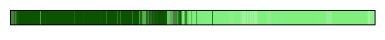

In [53]:
options(repr.plot.width = 154.196/72 * 1.5, repr.plot.height = 6/72 * 4)

ggplot(pd.fig_2.motif.beta.pesudostate$pd.anno) + geom_rect(aes(xmin = pt - 0.1, 
    xmax = pt + 0.1, fill = subtype), ymin = 0, ymax = 1, alpha = 0.5) + theme_pubr() + 
    scale_fill_manual(values = c("darkgreen", "lightgreen")) + coord_cartesian(expand = F) + 
    theme(legend.position = "none", axis.text.x = element_blank(), axis.ticks = element_blank())

ggsave(paste0("/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-12_figs/fig2D_beta_ps_anno.pdf"),width=154.196/72 * 1.5,
     height=6/72 * 4,useDingbats = F)

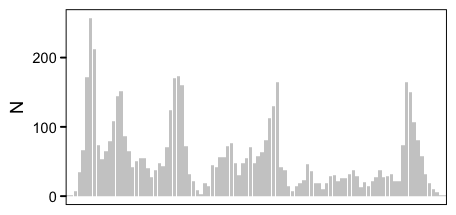

In [57]:
## beta ps bin 
options(repr.plot.width = 548.276/72/2, repr.plot.height = 258.924/72/2)
ps.bin.dat.sum <- fread('../dat/figdata/ps.bin.dat.sum.csv')

p <- ggplot(ps.bin.dat.sum %>% filter(celltype == "alpha") %>% droplevels(), aes(ps_bin, 
    N)) + geom_bar(stat = "identity", fill = "grey80") + theme_pubr() + theme(axis.title.x = element_blank()) + 
    scale_x_discrete(breaks = c(0, 50, 100))
print(p)
ggsave(p + theme(axis.title = element_blank(), axis.text = element_blank()), filename = "/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-05_figs/fig2D_alpha_ps_histogram.pdf", 
    width = 176/72, height = 36/72)

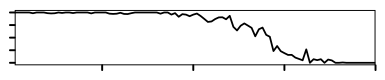

In [86]:
options(repr.plot.width = 154.196/72 * 1.5, repr.plot.height = 6/72 * 8)
pd <- ps.bin.dat.sum %>% filter(celltype == "alpha") %>% droplevels() %>% ungroup()%>%
    mutate(ps_bin.idx=as.numeric(factor(ps_bin,levels=ps_bin)))
#head(pd)
ggplot(pd) + geom_line(aes(ps_bin.idx, frac)) + theme_pubr()+coord_cartesian(expand = F)+
ylim(-0.05,1.05)+theme(text = element_blank())
ggsave(paste0("/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-12_figs/fig2D_alpha_ps_frac.pdf"),width=154.196/72 * 1.5,
     height=6/72 * 8,useDingbats = F)

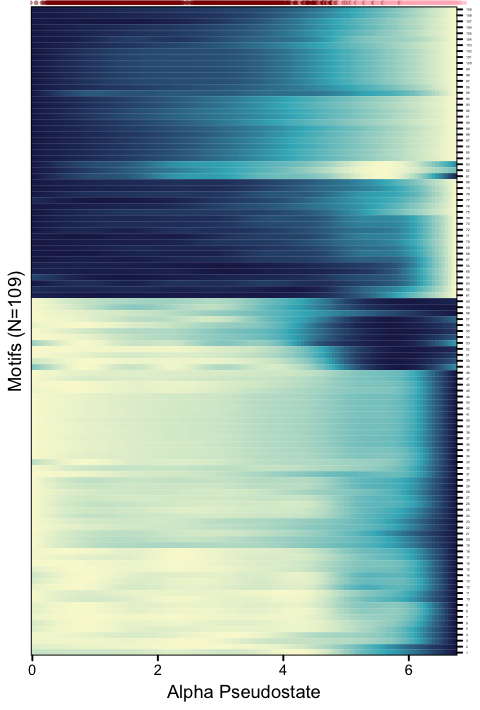

In [54]:
pd.fig_2.motif.alpha.pesudostate <- readRDS("../dat/figdata/fig_2.motif.alpha.pesudostate.hm.Rds")


pd <- pd.fig_2.motif.alpha.pesudostate$pd %>% as.data.frame() %>% rownames_to_column("motif") %>% 
    gather(key = "ps.idx", value = "zval", -1) %>% mutate(ps = (as.numeric(ps.idx) - 
    1) * 0.05, motif = factor(motif, levels = rev(rownames(pd.fig_2.motif.alpha.pesudostate$pd)))) %>% 
    select(-ps.idx)
l <- length(levels(pd$motif))

p1 <- ggplot(pd, aes(ps, as.numeric(motif))) + geom_tile(aes(fill = zval)) + theme_pubr() + 
    coord_cartesian(expand = F) + theme(axis.ticks.length = unit(1, "mm"), legend.position = "none", 
    axis.text.y  = element_text(size = 2), plot.margin = margin(0.5, 5, 5, 5, "pt")) + scale_fill_gradientn(colours = colorRampPalette(c(rgb(249, 
    249, 212, maxColorValue = 255), rgb(60, 181, 195, maxColorValue = 255), rgb(30, 
    35, 86, maxColorValue = 255)), space = "Lab")(50)) + scale_y_continuous(breaks = c(0, 
    l + 1), sec.axis = sec_axis(~., breaks = 1:l)) + ylab(paste0("Motifs (N=", l, 
    ")")) + xlab("Alpha Pseudostate")


p2 <- ggplot(pd.fig_2.motif.alpha.pesudostate$pd.anno, aes(pt, 1)) + geom_point(shape = 16, 
    size = 1, aes(color = subtype), alpha = 0.5) + 
    coord_cartesian(expand = F) + theme_void() +ylab("")+ theme(legend.position = "none", 
    plot.margin = margin(0.5, 8, 0, 5, "pt"), axis.title.y = element_text(size = 11, 
        vjust = 1, angle = 90, colour = "black", face = "plain", family = "Arial", 
         hjust = 0.5, lineheight = 0.5)) + scale_color_manual(values = c("darkred", 
    "lightpink"))


options(repr.plot.width = 4, repr.plot.height = 2.5/46*l)
ggarrange(p2, p1, nrow = 2, heights = c(1, l))

#ggsave( filename = '/Users/frank/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/fig2/fig_2B.motif_alpha_ps_idxlabel.pdf', width = 4, height = 2.5/46*l,
# useDingbats = F)
#fwrite(data.frame(idx=1:l,motif=levels(pd$motif)),'/Users/frank/Dropbox (UCSD_Epigenomics)/Islet_snATAC/panel_pdfs/fig2/fig_2B.motif_alpha_ps_idxlabel.csv')
#write.csv(pd.fig_2.motif.alpha.pesudostate$pd,"../dat/figdata/motif.alpha.ps.step0.05.csv")
#ggsave( filename = './fig_2B.motif_alpha_ps.pdf', width = 4, height = 2.5/46*l, useDingbats = F)


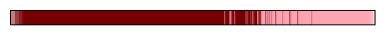

In [56]:
options(repr.plot.width = 154.196/72 * 1.5, repr.plot.height = 6/72 * 4)

ggplot(pd.fig_2.motif.alpha.pesudostate$pd.anno) + geom_rect(aes(xmin = pt - 0.1, 
    xmax = pt + 0.1, fill = subtype), ymin = 0, ymax = 1, alpha = 0.5) + theme_pubr() + 
    scale_fill_manual(values = c("darkred", "lightpink")) + coord_cartesian(expand = F) + 
    theme(legend.position = "none", axis.text.x = element_blank(), axis.ticks = element_blank())

ggsave(paste0("/Users/frank/Dropbox (UCSD_Epigenomics)/projects/islet/slides/2019-03-12_figs/fig2D_alpha_ps_anno.pdf"),width=154.196/72 * 1.5,
     height=6/72 * 4,useDingbats = F)

In [1]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] jsonlite_1.5 formatR_1.5 

loaded via a namespace (and not attached):
 [1] compiler_3.5.1  IRdisplay_0.7.0 pbdZMQ_0.3-3    tools_3.5.1    
 [5] htmltools_0.3.6 base64enc_0.1-3 crayon_1.3.4    Rcpp_0.12.19   
 [9] uuid_0.1-2      IRkernel_0.8.15 digest_0.6.18   repr_0.19.1    
[13] evaluate_0.12  